<a href="https://colab.research.google.com/github/Robot-Wealth/trader-tales/blob/master/research-examples/outperformance-reversion/SPY_TLT_Rebalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPY-TLT Rebalance Trade

In [2]:
install.packages(c("quantmod", "roll"))
library("quantmod")
library("roll")
library("tidyverse")

options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’, ‘RcppParallel’, ‘RcppArmadillo’


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::first()  masks xts::first()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::last()   masks xts::last()
ℹ Use the conflicted packag

In [5]:
quantmod::getSymbols(c("SPY", "TLT"), src = "yahoo")

[1] "SPY" "TLT"

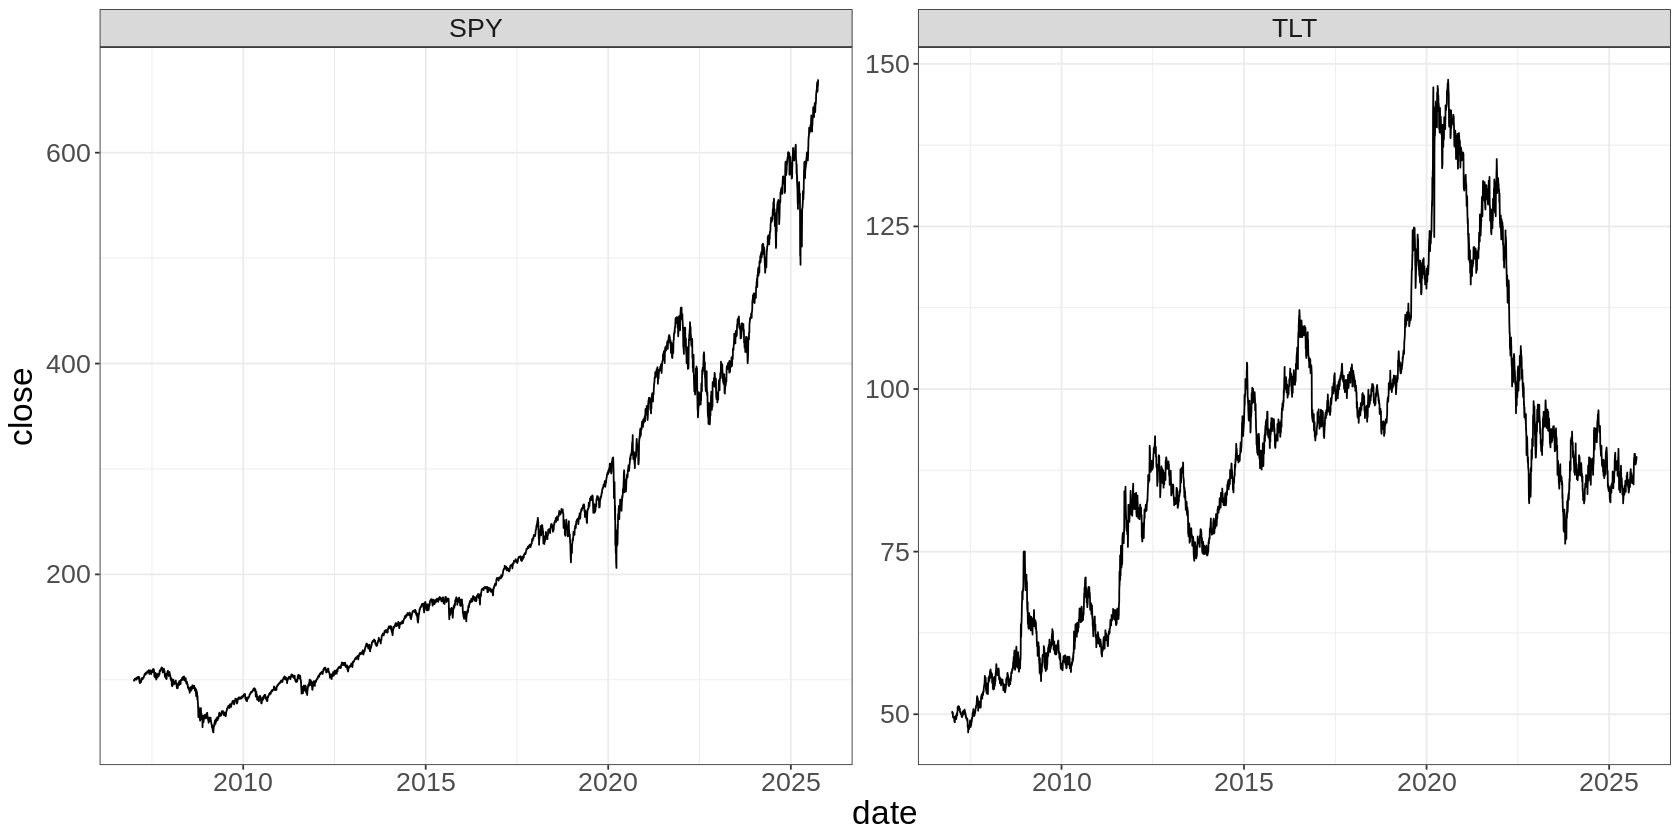

In [9]:
# make long df of adjusted closing prices

assets <- list(SPY = SPY, TLT = TLT)

prices <- assets %>%
  imap_dfr(~ {
    tibble(
      date   = as.Date(index(.x)),
      ticker = .y,
      close  = as.numeric(.x[, paste0(.y, ".Adjusted")])
    )
  }) %>%
  arrange(date, ticker)

prices %>%
  ggplot(aes(x = date, y = close)) +
  geom_line() +
  facet_wrap(~ticker, scales = "free_y")

In [12]:
analysis_df <- prices %>%
  mutate(year = year(date), month = month(date), day = day(date)) %>%
  arrange(date)

# get rid of incomplete months
incomplete_months <- analysis_df %>%
  group_by(ticker, year, month) %>%
  summarise(trading_days = n(), .groups = "keep") %>%
  filter(trading_days < 15)

# get the trading day of the month (tdm)
analysis_df <- analysis_df %>%
  anti_join(incomplete_months, by = c("ticker", "year", "month")) %>%
  group_by(ticker, year, month) %>%
  mutate(tdm = row_number()) %>%
  ungroup() %>%
  select(date, ticker, close, tdm) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(log_return = log(close / dplyr::lag(close, n = 1))) %>%
  na.omit()

analysis_df %>%
  head()

date,ticker,close,tdm,log_return
<date>,<chr>,<dbl>,<int>,<dbl>
2007-01-04,SPY,99.90016,2,0.002120297
2007-01-04,TLT,50.37909,2,0.006045081
2007-01-05,SPY,99.10334,3,-0.008008159
2007-01-05,TLT,50.15978,3,-0.004362637
2007-01-08,SPY,99.56169,4,0.004614319
2007-01-08,TLT,50.24979,4,0.001792737


In [17]:
equity_bond_outperformance <- analysis_df %>%
  # get observations where both ETFs had a price
  pivot_wider(id_cols = c(date, tdm), names_from = ticker, values_from = log_return) %>%
  na.omit() %>%
  pivot_longer(cols = c(SPY, TLT), names_to = "ticker", values_to = "log_return") %>%
  mutate(
    month_split = case_when(tdm <= 15 ~ 1, TRUE ~ 2),
    # month and year variables
    month = month(date),
    year = year(date)
  ) %>%
  # get returns to both parts of the month
  group_by(ticker, year, month, month_split) %>%
  summarise(partial_return = sum(log_return)) %>%
  ungroup() %>%
  # calculate equity-bond outperformance
  pivot_wider(names_from = ticker, values_from = partial_return) %>%
  mutate(eq_bond_outperf = log(1 + (exp(SPY)-1) - (exp(TLT)-1))) %>%
  pivot_wider(id_cols = c(year, month), names_from = month_split, names_prefix = "part_mnth_", values_from = eq_bond_outperf)

equity_bond_outperformance %>%
  head()

`summarise()` has grouped output by 'ticker', 'year', 'month'. You can override
using the `.groups` argument.


year,month,part_mnth_1,part_mnth_2
<dbl>,<dbl>,<dbl>,<dbl>
2007,1,0.033948935,-0.0007047117
2007,2,0.003102875,-0.0574805533
2007,3,0.021187157,0.0073493426
2007,4,0.036148496,-0.0016129809
2007,5,0.041753852,0.0143007879
2007,6,0.027936781,-0.0342091449


`geom_smooth()` using formula = 'y ~ x'


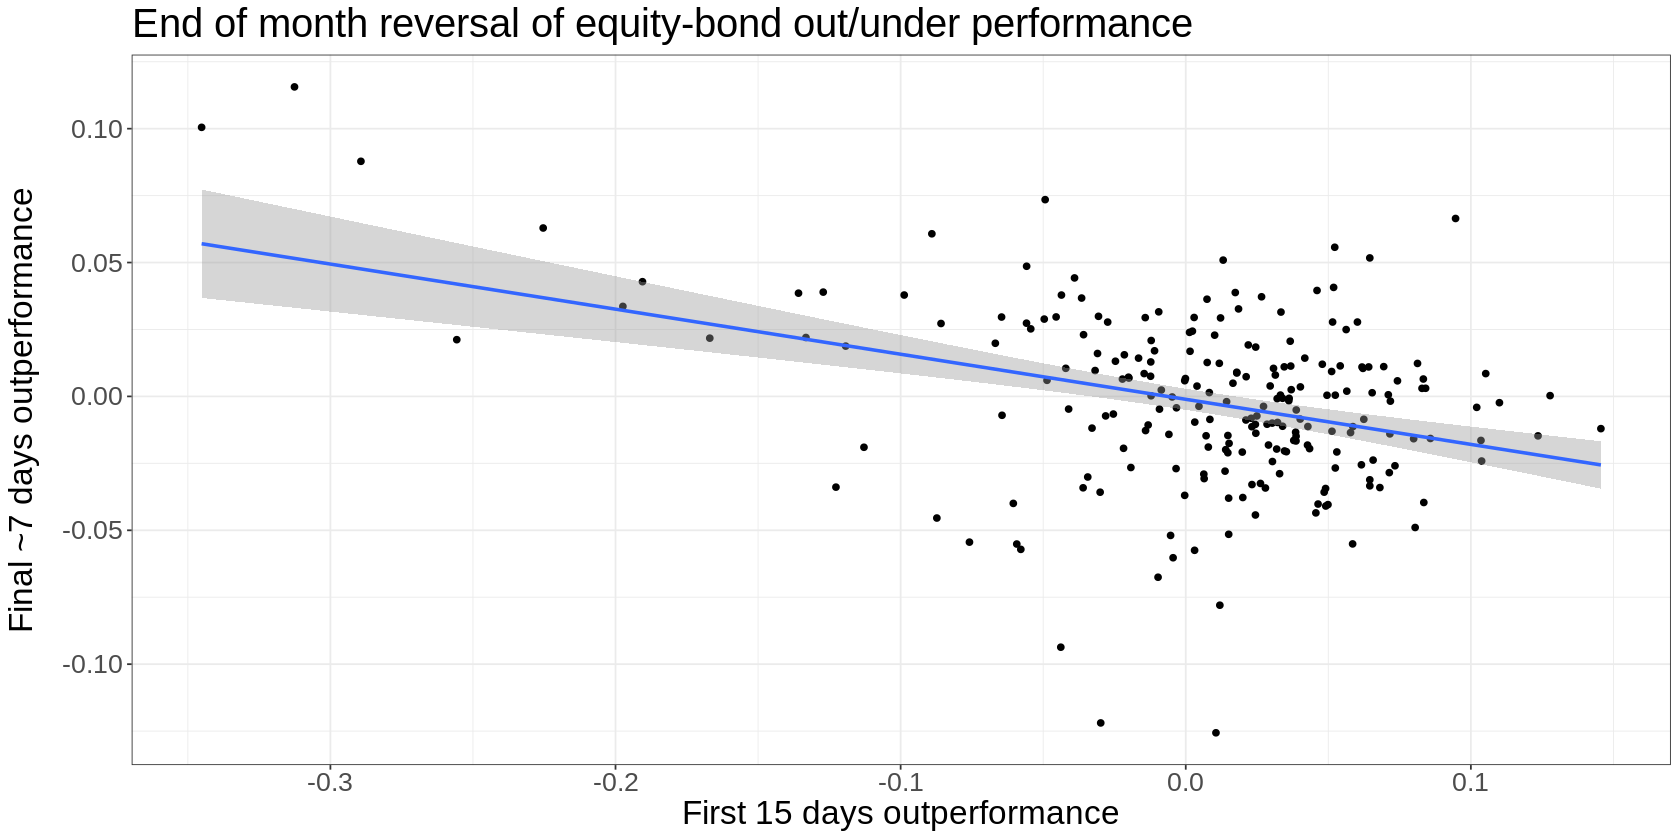

In [19]:
equity_bond_outperformance %>%
  ggplot(aes(x = part_mnth_1, y = part_mnth_2)) +
    geom_point() +
    geom_smooth(method = "lm") +
    labs(
      x = "First 15 days outperformance",
      y = "Final ~7 days outperformance",
      title = "End of month reversal of equity-bond out/under performance"
    )

`geom_smooth()` using formula = 'y ~ x'


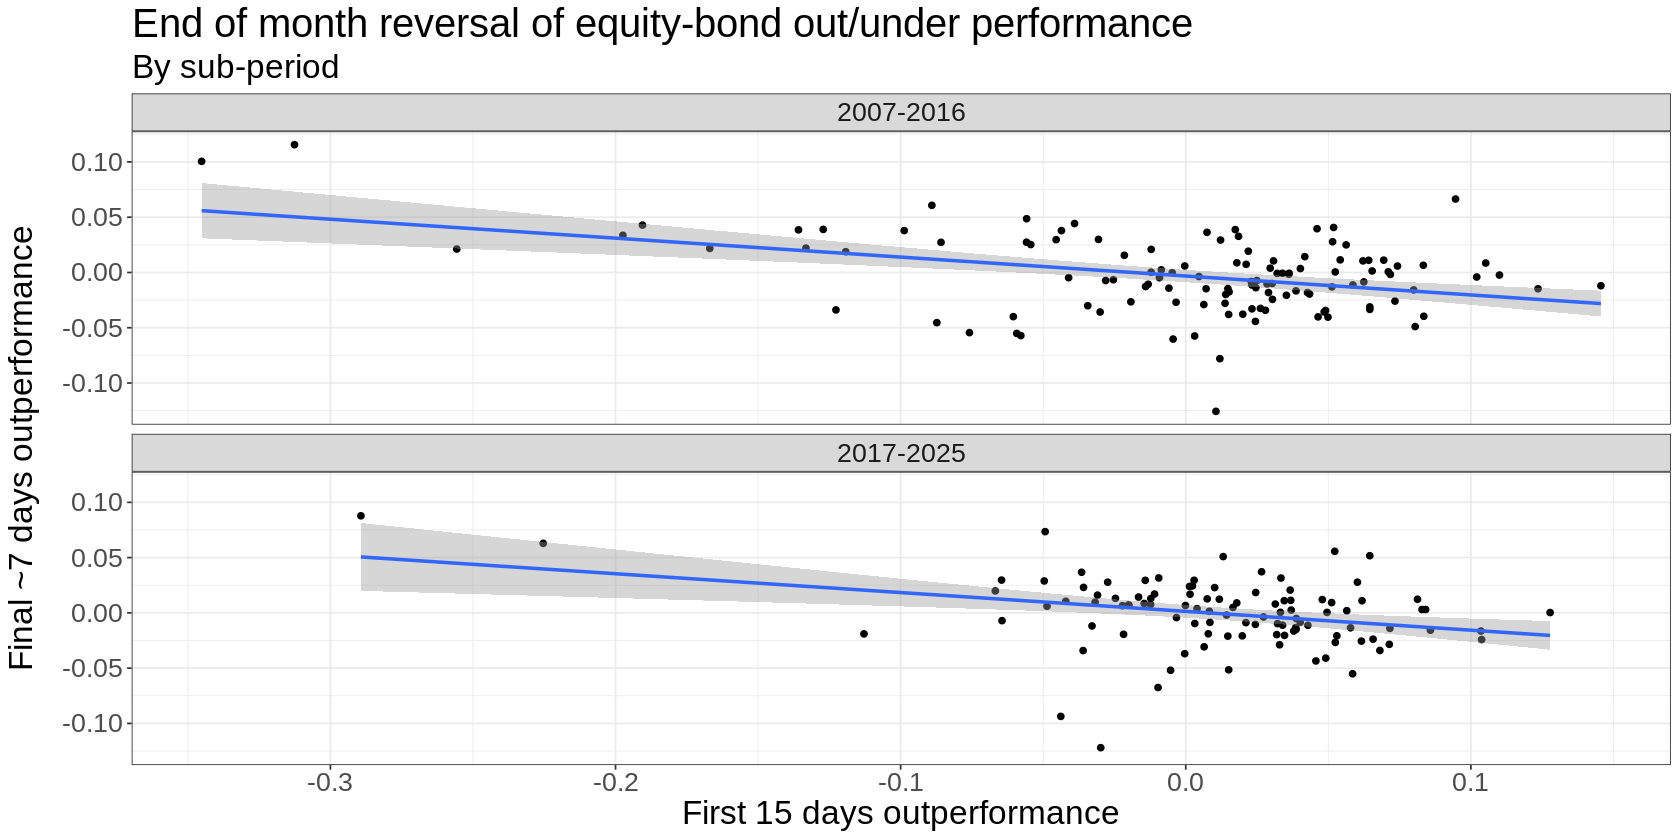

In [26]:
equity_bond_outperformance %>%
  mutate(period = case_when(year <= 2016 ~ "2007-2016", TRUE ~ "2017-2025")) %>%
  ggplot(aes(x = part_mnth_1, y = part_mnth_2)) +
    geom_point() +
    geom_smooth(method = "lm") +
    facet_wrap(~period, ncol = 1) +
    labs(
      x = "First 15 days outperformance",
      y = "Final ~7 days outperformance",
      title = "End of month reversal of equity-bond out/under performance",
      subtitle = "By sub-period"
    )

`geom_smooth()` using formula = 'y ~ x'


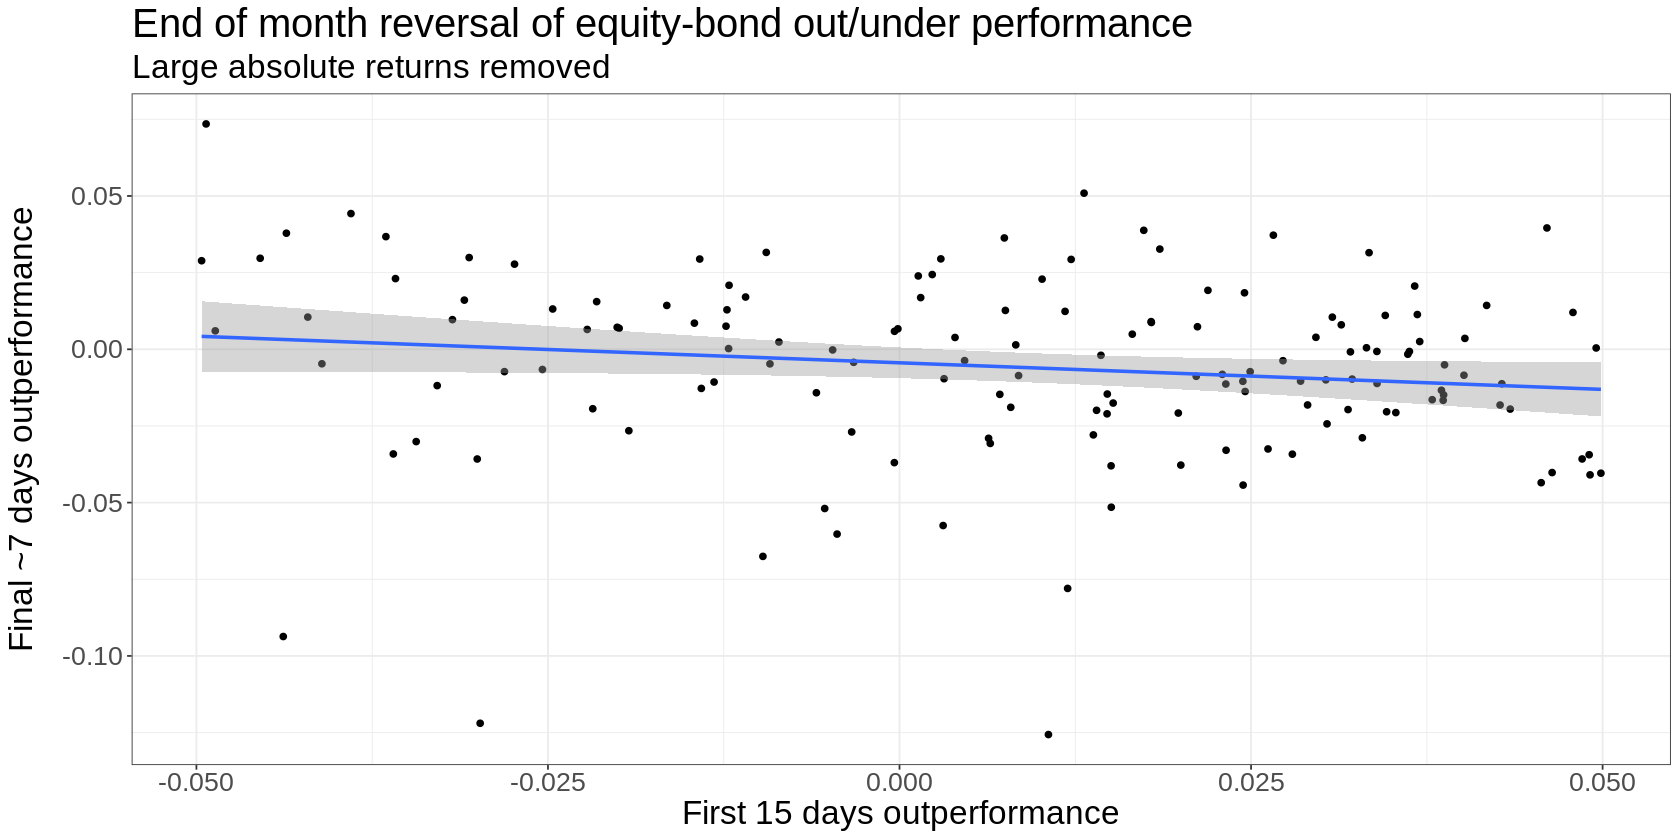

In [38]:
# take out extremes
equity_bond_outperformance %>%
  filter(abs(part_mnth_1) < 0.05) %>%
  ggplot(aes(x = part_mnth_1, y = part_mnth_2)) +
    geom_point() +
    geom_smooth(method = "lm") +
    labs(
      x = "First 15 days outperformance",
      y = "Final ~7 days outperformance",
      title = "End of month reversal of equity-bond out/under performance",
      subtitle = "Large absolute returns removed"
    )

`geom_smooth()` using formula = 'y ~ x'


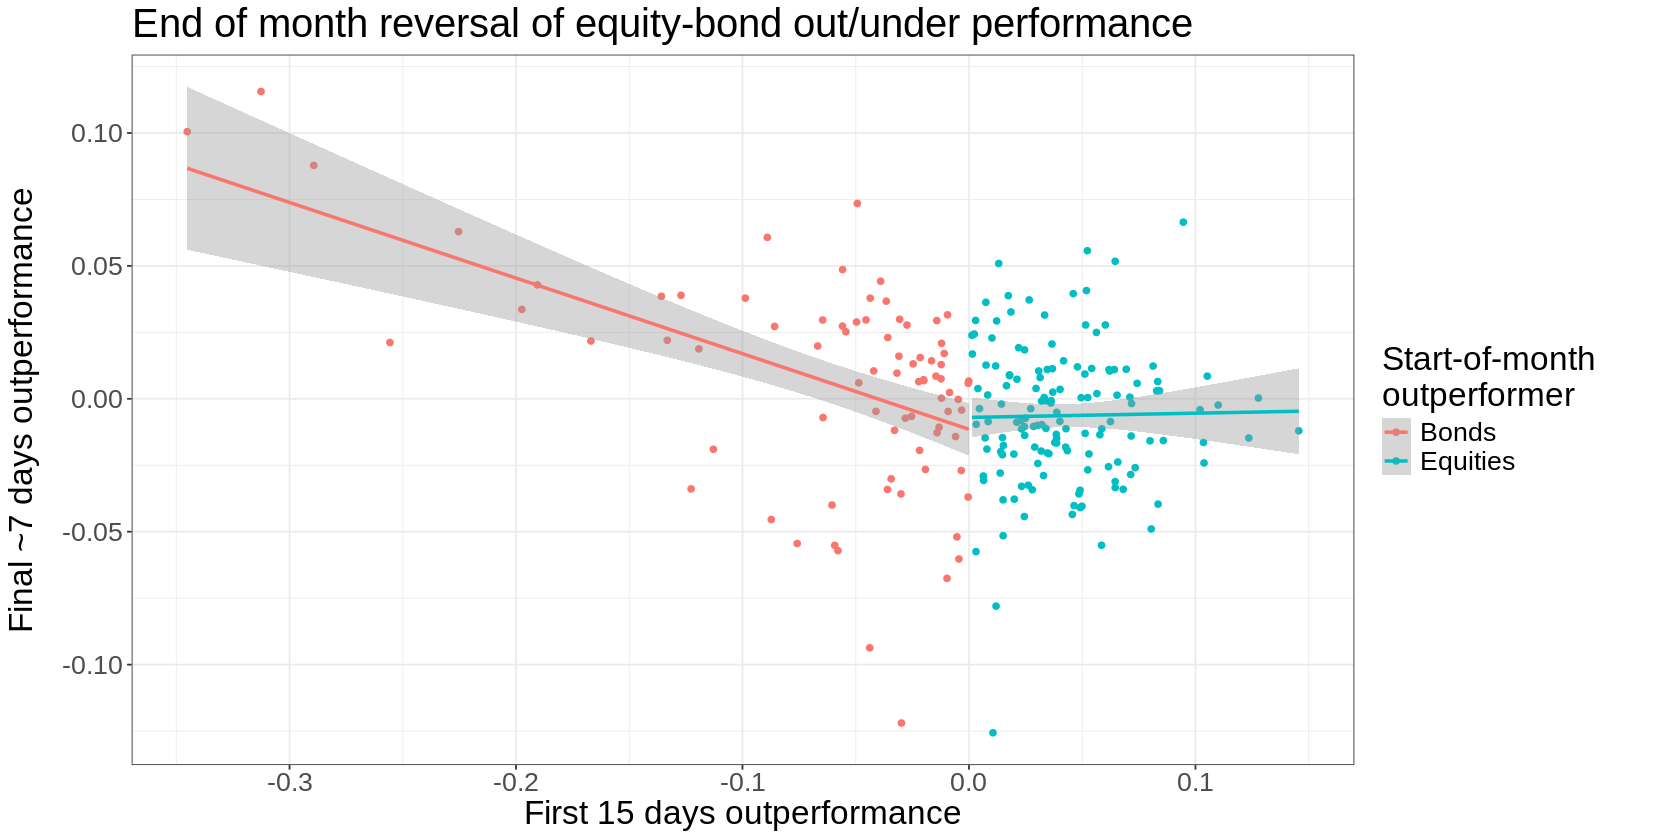

In [37]:
equity_bond_outperformance %>%
  mutate(StartMonthPerformer = case_when(part_mnth_1 < 0 ~ "Bonds", TRUE ~ "Equities")) %>%
  ggplot(aes(x = part_mnth_1, y = part_mnth_2, colour = StartMonthPerformer)) +
    geom_point() +
    geom_smooth(method = "lm") +
    labs(
      x = "First 15 days outperformance",
      y = "Final ~7 days outperformance",
      title = "End of month reversal of equity-bond out/under performance",
      colour = "Start-of-month\noutperformer"
    )

In [41]:
head(analysis_df)

date,ticker,close,tdm,log_return
<date>,<chr>,<dbl>,<int>,<dbl>
2007-01-04,SPY,99.90016,2,0.002120297
2007-01-04,TLT,50.37909,2,0.006045081
2007-01-05,SPY,99.10334,3,-0.008008159
2007-01-05,TLT,50.15978,3,-0.004362637
2007-01-08,SPY,99.56169,4,0.004614319
2007-01-08,TLT,50.24979,4,0.001792737


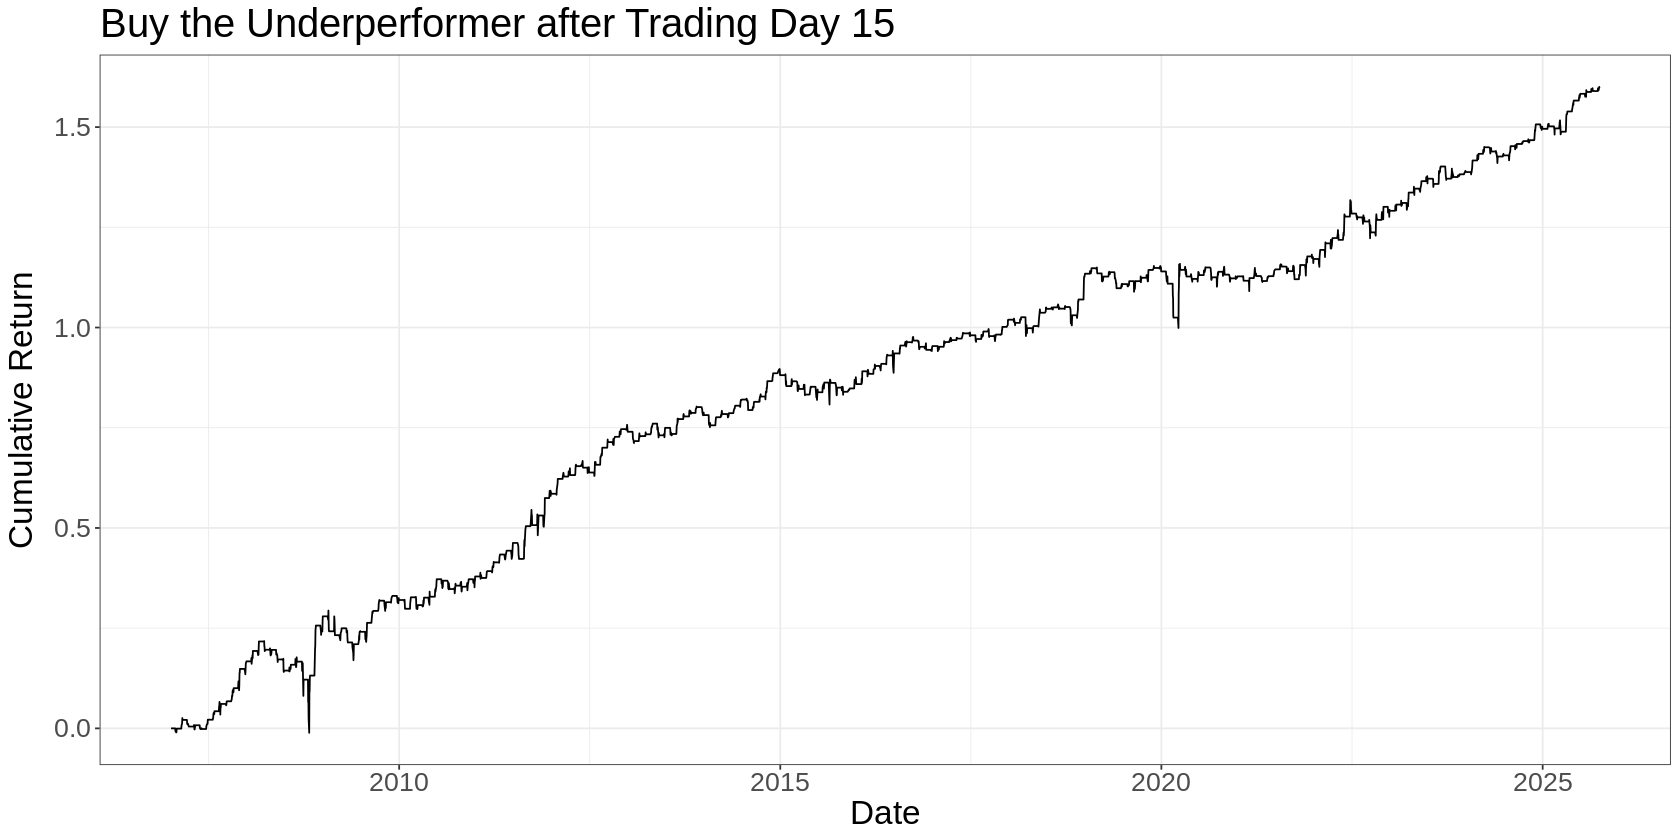

In [55]:
equity_bond_outperformance %>%
  right_join(analysis_df %>% mutate(year = year(date), month = month(date)), by = c("month", "year")) %>%
  mutate(
  position = case_when(
    part_mnth_1 < 0 & ticker == "SPY" & tdm > 15 ~ 1,
    part_mnth_1 > 0 & ticker == "TLT" & tdm > 15 ~ 1,
    TRUE ~ 0
  )
) %>%
group_by(date) %>%
summarise(strategy_return = sum(position * log_return)) %>%
mutate(cum_strategy_return = cumsum(strategy_return)) %>%
ggplot(aes(x = date, y = cum_strategy_return)) +
geom_line() +
labs(
 x = "Date",
 y = "Cumulative Return",
 title = "Buy the Underperformer after Trading Day 15"
)

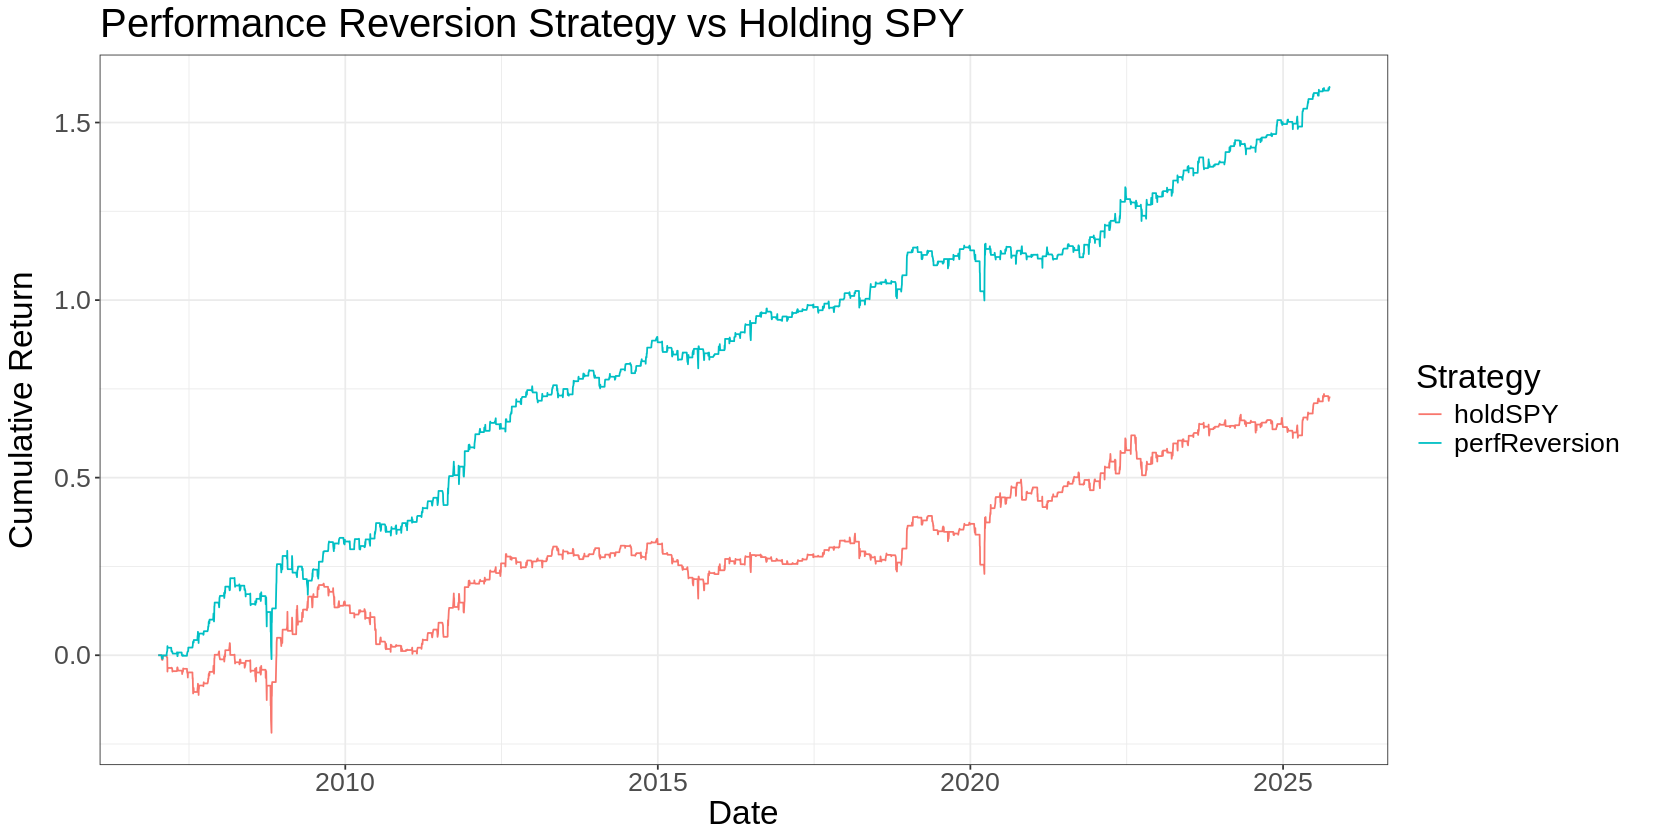

In [56]:
equity_bond_outperformance %>%
  right_join(analysis_df %>% mutate(year = year(date), month = month(date)), by = c("month", "year")) %>%
  mutate(
  position = case_when(
    part_mnth_1 < 0 & ticker == "SPY" & tdm > 15 ~ 1,
    part_mnth_1 > 0 & ticker == "TLT" & tdm > 15 ~ 1,
    TRUE ~ 0
  ),
  # compare with holding spy over same part of month
  spy_return = case_when(ticker == "SPY" & tdm > 15 ~ log_return, TRUE ~ 0)
) %>%
group_by(date) %>%
summarise(
 strategy_return = sum(position * log_return),
 spy_return = sum(spy_return)
 ) %>%
mutate(
 perfReversion = cumsum(strategy_return),
 holdSPY = cumsum(spy_return)
 ) %>%
pivot_longer(c(perfReversion, holdSPY), names_to = "Strategy", values_to = "Cum. Return") %>%
ggplot(aes(x = date, y = `Cum. Return`, colour = Strategy)) +
geom_line() +
labs(
 x = "Date",
 y = "Cumulative Return",
 title = "Performance Reversion Strategy vs Holding SPY"
)

In [ ]:

positions_df <- prices_df %>%
  # get observations where both ETFs had a price
  pivot_wider(id_cols = c(date, tdm), names_from = ticker, values_from = logreturns) %>%
  na.omit() %>%
  pivot_longer(cols = c({{stock_ticker}}, {{bond_ticker}}), names_to = "ticker", values_to = "log_return") %>%
  mutate(
    # month split - split on month_split_day
    month_split = case_when(tdm <= month_split_day ~ 1, TRUE ~ 2),
    # month and year variables
    month = month(date),
    year = year(date)
  ) %>%
  # get cumulative returns to both parts of the month
  group_by(ticker, year, month, month_split) %>%
  mutate(partial_return = cumsum(log_return)) %>%
  # calculate equity-bond outperformance
  pivot_wider(id_cols = c(date, tdm), names_from = ticker, values_from = partial_return) %>%
  mutate(eq_bond_outperf = log(1 + (exp(!!! rlang::syms(stock_ticker))-1) - (exp(!!! rlang::syms(bond_ticker))-1))) %>%
  # calculate stock and bond positions on signal day - we can't know which outperformed until the close on signal day so these positions go on at the close of the next day in backtest
  mutate(
    stock_position = case_when(
      eq_bond_outperf < 0 & tdm == month_split_day ~ 1,
      TRUE ~ as.numeric(NA)
    ),
    bond_position = case_when(
      eq_bond_outperf > 0 & tdm == month_split_day ~ 1,
      TRUE ~ as.numeric(NA)
    )
  ) %>%
  # group by year and month, then fill forward positions to eom
  mutate(
    month = month(date),
    year = year(date)
  ) %>%
  group_by(year, month) %>%
  mutate(
    tdem = tdm - max(tdm) - 1) %>%
  # fill forward positions
  fill(stock_position, .direction = "down") %>%
  fill(bond_position, .direction = "down")

if(trade_som) {
  positions_df <- positions_df %>%
    # we want to be long stocks for som_trade_length days from the end of the month in months when we were long bonds
    # put this on on the last day of the month
    ungroup() %>%
    mutate(
      stock_position = case_when(
        ((tdem == -1 | tdem == -2) & bond_position == 1) | (tdm == 1 & dplyr::lag(bond_position) == 1) | (stock_position == 1) ~ 1,  # signal occurs on last day of the month...but in backtest we lag signal to next trading day
        (tdm <= som_trade_length-2) & !(tdm == 1 & dplyr::lag(bond_position) == 1) ~ as.numeric(NA),  # we'll fill forward these NAs from EOM to capture start of month position. (tdm <= som_trade_length-2) because we buy on the last day of the month, and sell on the 5th day
        TRUE ~ 0
      )
    ) %>%
    fill(stock_position, .direction = "down")
}

positions_df <- positions_df %>%
  ungroup() %>%
  # remaining NA positions get zero
  replace_na(list(stock_position = 0, bond_position = 0)) %>%
  # get bond position off on the last day of the month (since we lag positions in backtest, we can actually get this off on the 2nd to last day of month)
  mutate(
    stock_position = case_when(tdem %in% c(-1, -2) & bond_position != 1 ~ 0, TRUE ~ stock_position),
    bond_position = case_when(tdem %in% c(-1, -2) ~ 0, TRUE ~ bond_position)
  )

positions_df <- positions_df %>%
  select(date, stock_position, bond_position) %>%
  rename_with(.cols = ends_with("_position"), .fn = ~ {tickers}) %>%
  pivot_longer(cols = c(-date), names_to = 'ticker', values_to = 'position') %>%
  left_join(prices_df %>% select(ticker, date, close, closeadjusted), by = c("ticker", "date")) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(lag_position = dplyr::lag(position))

## Does it show up elsewhere?

[1] "IEF"

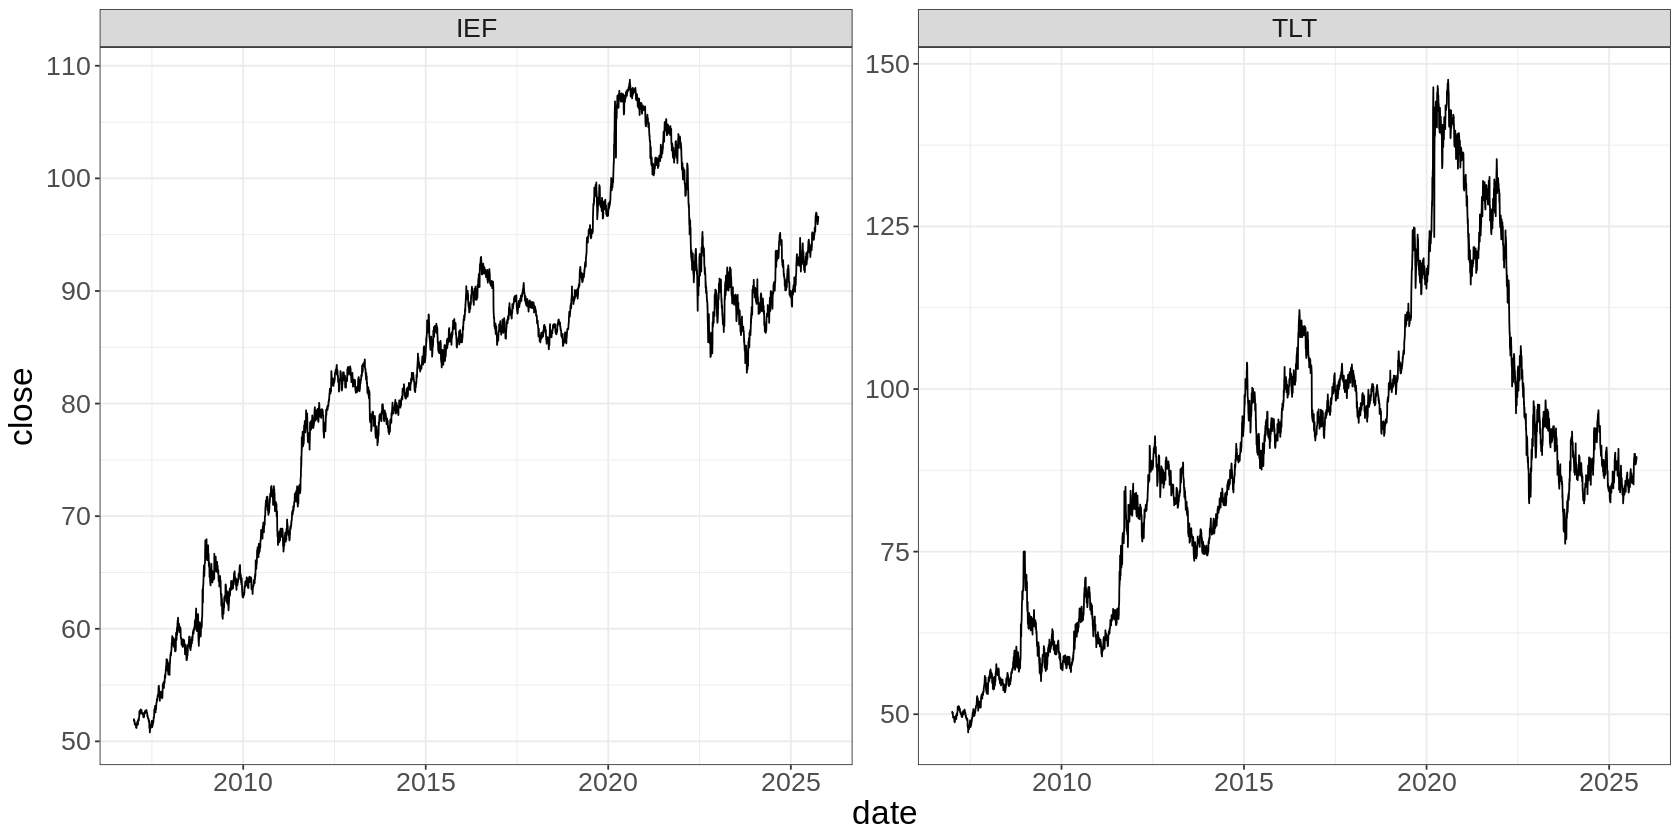

In [28]:
# make long df of adjusted closing prices
getSymbols("IEF", source = "yahoo")
bond_assets <- list(IEF = IEF, TLT = TLT)

bond_prices <- bond_assets %>%
  imap_dfr(~ {
    tibble(
      date   = as.Date(index(.x)),
      ticker = .y,
      close  = as.numeric(.x[, paste0(.y, ".Adjusted")])
    )
  }) %>%
  arrange(date, ticker)

bond_prices %>%
  ggplot(aes(x = date, y = close)) +
  geom_line() +
  facet_wrap(~ticker, scales = "free_y")

`summarise()` has grouped output by 'ticker', 'year', 'month'. You can override
using the `.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


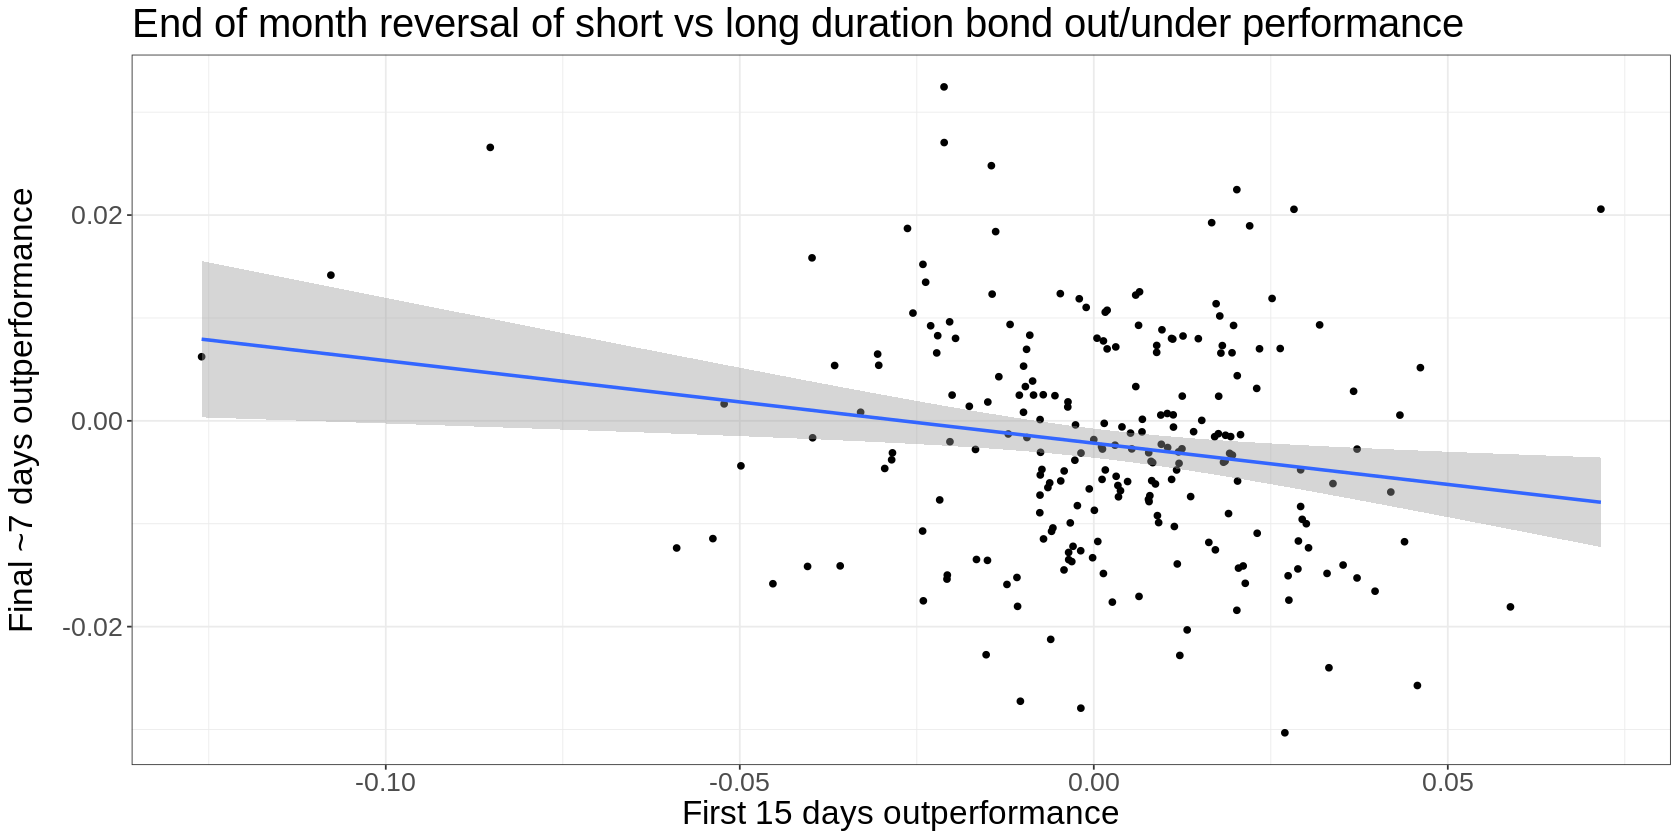

In [33]:
bond_analysis_df <- bond_prices %>%
  mutate(year = year(date), month = month(date), day = day(date)) %>%
  arrange(date)

# get rid of incomplete months
incomplete_months <- bond_analysis_df %>%
  group_by(ticker, year, month) %>%
  summarise(trading_days = n(), .groups = "keep") %>%
  filter(trading_days < 15)

# get the trading day of the month (tdm)
bond_analysis_df <- bond_analysis_df %>%
  anti_join(incomplete_months, by = c("ticker", "year", "month")) %>%
  group_by(ticker, year, month) %>%
  mutate(tdm = row_number()) %>%
  ungroup() %>%
  select(date, ticker, close, tdm) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(log_return = log(close / dplyr::lag(close, n = 1))) %>%
  na.omit()

short_long_bond_outperformance <- bond_analysis_df %>%
  # get observations where both ETFs had a price
  pivot_wider(id_cols = c(date, tdm), names_from = ticker, values_from = log_return) %>%
  na.omit() %>%
  pivot_longer(cols = c(IEF, TLT), names_to = "ticker", values_to = "log_return") %>%
  mutate(
    month_split = case_when(tdm <= 15 ~ 1, TRUE ~ 2),
    # month and year variables
    month = month(date),
    year = year(date)
  ) %>%
  # get returns to both parts of the month
  group_by(ticker, year, month, month_split) %>%
  summarise(partial_return = sum(log_return)) %>%
  ungroup() %>%
  # calculate equity-bond outperformance
  pivot_wider(names_from = ticker, values_from = partial_return) %>%
  mutate(short_long_bond_outperf = log(1 + (exp(IEF)-1) - (exp(TLT)-1))) %>%
  pivot_wider(id_cols = c(year, month), names_from = month_split, names_prefix = "part_mnth_", values_from = short_long_bond_outperf)

short_long_bond_outperformance %>%
  ggplot(aes(x = part_mnth_1, y = part_mnth_2)) +
    geom_point() +
    geom_smooth(method = "lm") +
    labs(
      x = "First 15 days outperformance",
      y = "Final ~7 days outperformance",
      title = "End of month reversal of short vs long duration bond out/under performance"
    )

[1] "IJR"

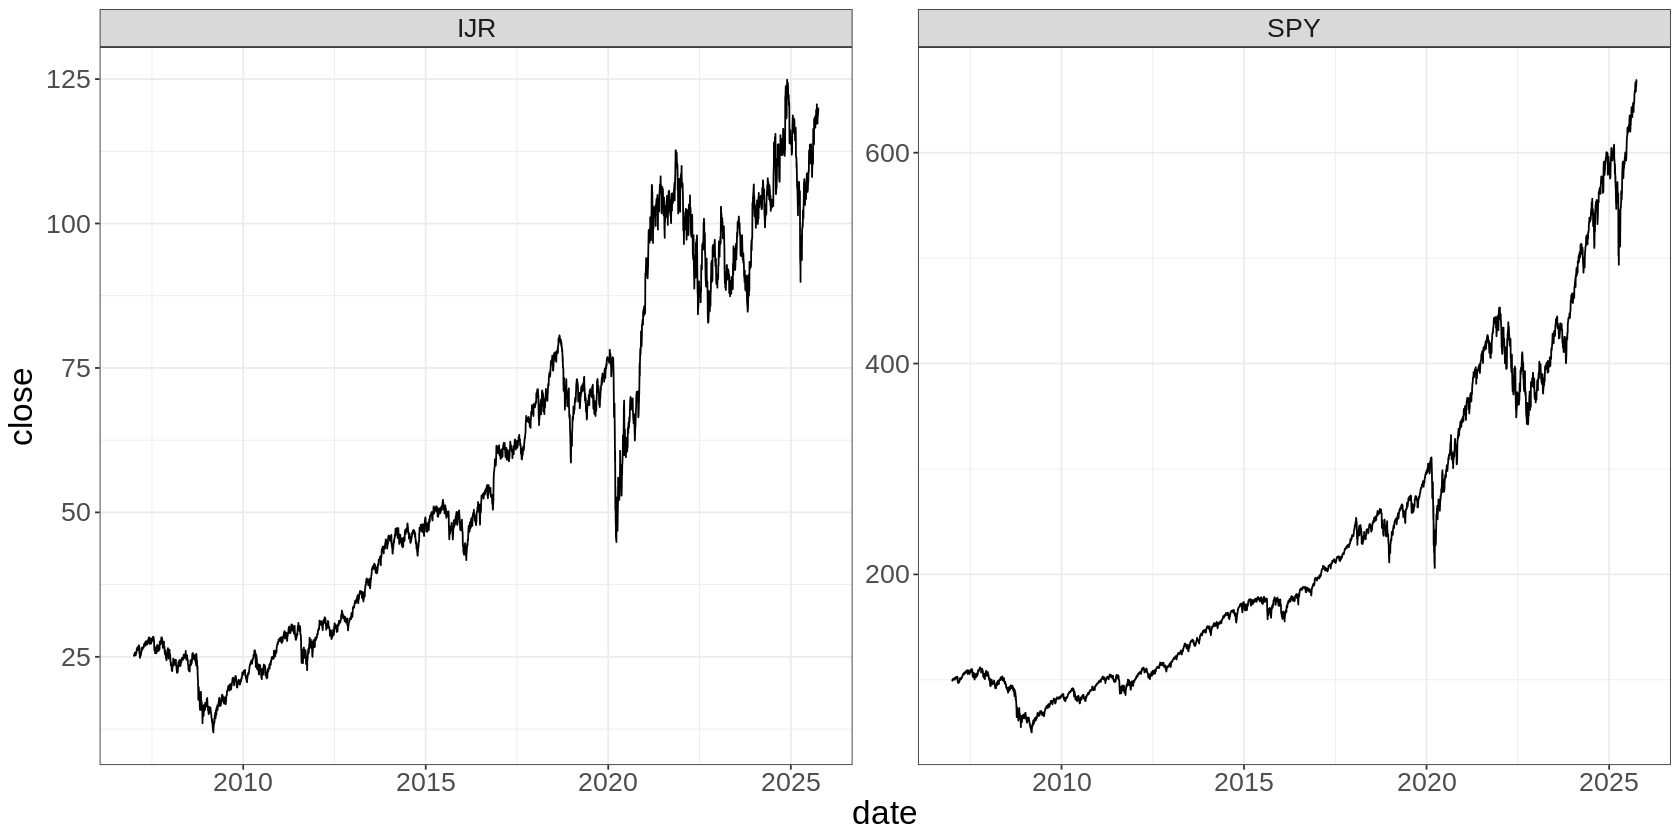

In [34]:
# make long df of adjusted closing prices
getSymbols("IJR", source = "yahoo")
equity_assets <- list(IJR = IJR, SPY = SPY)

equity_prices <- equity_assets %>%
  imap_dfr(~ {
    tibble(
      date   = as.Date(index(.x)),
      ticker = .y,
      close  = as.numeric(.x[, paste0(.y, ".Adjusted")])
    )
  }) %>%
  arrange(date, ticker)

equity_prices %>%
  ggplot(aes(x = date, y = close)) +
  geom_line() +
  facet_wrap(~ticker, scales = "free_y")

`summarise()` has grouped output by 'ticker', 'year', 'month'. You can override
using the `.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


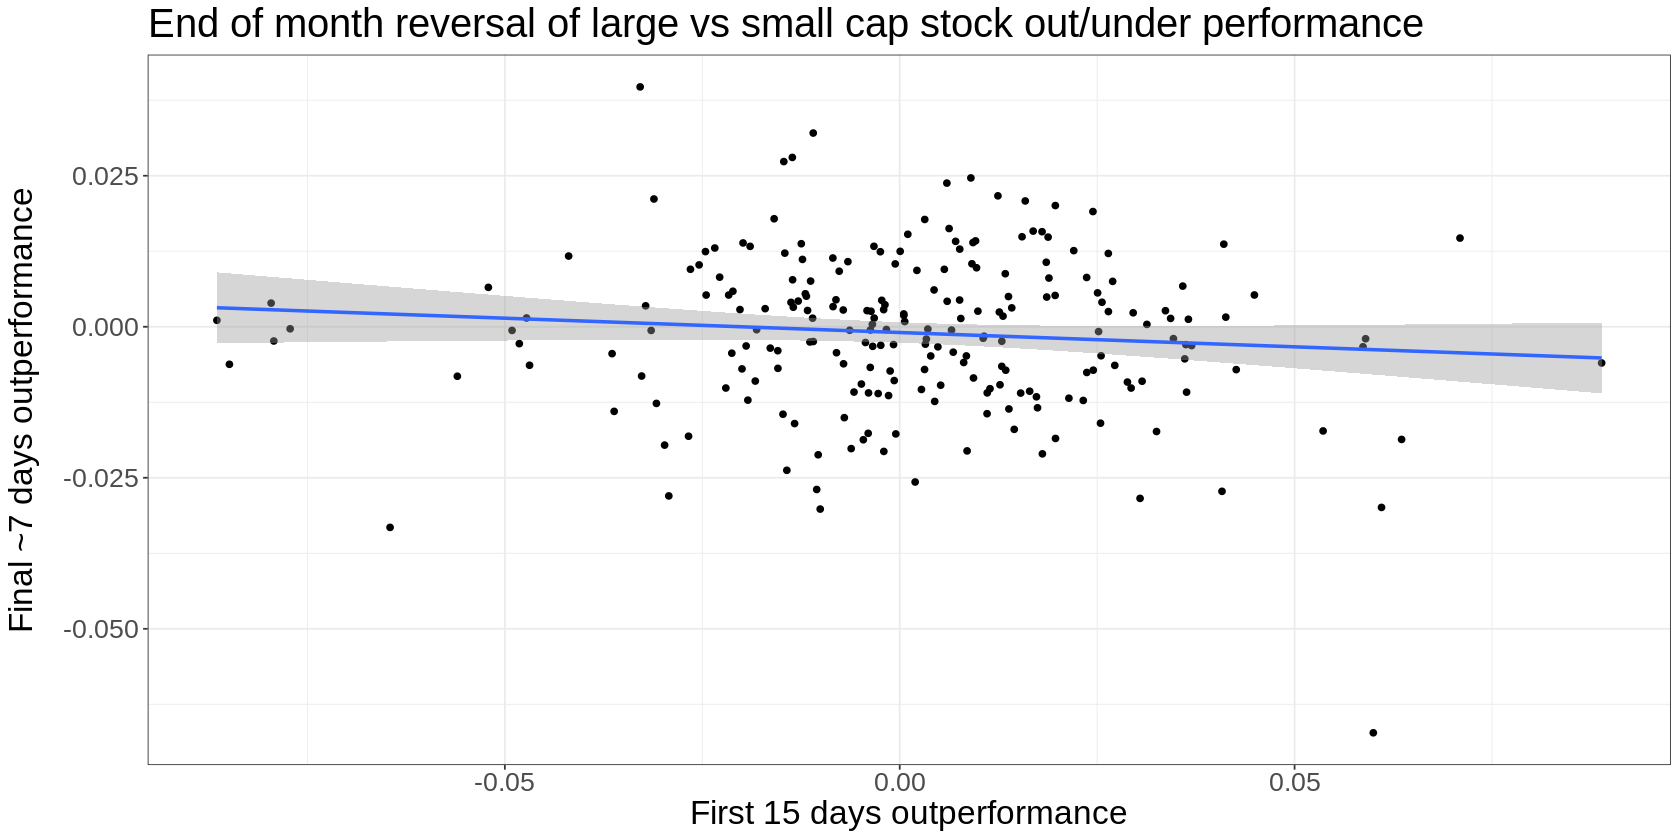

In [35]:
equity_analysis_df <- equity_prices %>%
  mutate(year = year(date), month = month(date), day = day(date)) %>%
  arrange(date)

# get rid of incomplete months
incomplete_months <- equity_analysis_df %>%
  group_by(ticker, year, month) %>%
  summarise(trading_days = n(), .groups = "keep") %>%
  filter(trading_days < 15)

# get the trading day of the month (tdm)
equity_analysis_df <- equity_analysis_df %>%
  anti_join(incomplete_months, by = c("ticker", "year", "month")) %>%
  group_by(ticker, year, month) %>%
  mutate(tdm = row_number()) %>%
  ungroup() %>%
  select(date, ticker, close, tdm) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(log_return = log(close / dplyr::lag(close, n = 1))) %>%
  na.omit()

small_large_stock_outperformance <- equity_analysis_df %>%
  # get observations where both ETFs had a price
  pivot_wider(id_cols = c(date, tdm), names_from = ticker, values_from = log_return) %>%
  na.omit() %>%
  pivot_longer(cols = c(IJR, SPY), names_to = "ticker", values_to = "log_return") %>%
  mutate(
    month_split = case_when(tdm <= 15 ~ 1, TRUE ~ 2),
    # month and year variables
    month = month(date),
    year = year(date)
  ) %>%
  # get returns to both parts of the month
  group_by(ticker, year, month, month_split) %>%
  summarise(partial_return = sum(log_return)) %>%
  ungroup() %>%
  # calculate outperformance
  pivot_wider(names_from = ticker, values_from = partial_return) %>%
  mutate(small_large_cap_outperf = log(1 + (exp(SPY)-1) - (exp(IJR)-1))) %>%
  pivot_wider(id_cols = c(year, month), names_from = month_split, names_prefix = "part_mnth_", values_from = small_large_cap_outperf)

small_large_stock_outperformance %>%
  ggplot(aes(x = part_mnth_1, y = part_mnth_2)) +
    geom_point() +
    geom_smooth(method = "lm") +
    labs(
      x = "First 15 days outperformance",
      y = "Final ~7 days outperformance",
      title = "End of month reversal of large vs small cap stock out/under performance"
    )